In [116]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-116-f0b59591d109>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [117]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)
j = 0
# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss)
for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = 0

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/2

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(5,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
    labels[j] = 1 # horiz
  else:
    G[:,i1:i1+i2] = 1 #ver
    labels[j] = 0
  j+=1
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [118]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

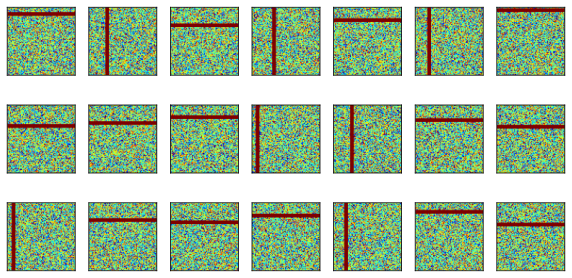

In [119]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [120]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,1),             # output size: 1
      )

    def forward(self,x):
      return self.enc(x).squeeze()

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [121]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32])
 
Loss:
tensor(0.6941, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [122]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [123]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

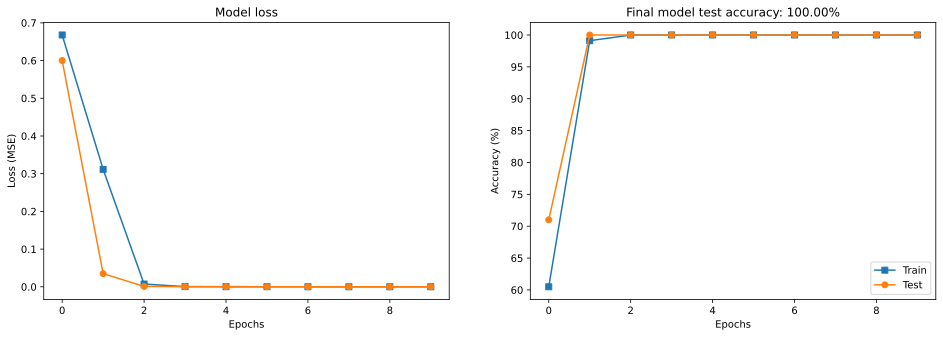

In [124]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [125]:
from skimage.draw import line_aa
n = 91
# mat = np.zeros((31,31),dtype = np.uint8)
dat = [[i for i in range(n)],[i for i in range(n)]]
ce = -1
pi= -91
labels = []
slope = []


for i in range(n):
  mat = np.zeros((91,91),dtype = np.uint8)
  ce -= int(bool(i) )
  pi += int(bool(i) )
  cc ,vr ,val = line_aa( ce,   0,   pi,   90)
  labels.append(1) #hor
  mat[cc,vr] = val *255
  slope.append((ce-0)/(pi-90))
  dat[0][i] = mat
cc = 0
qc =30
for j in range(n):
  mat = np.zeros((91,91),dtype = np.uint8)
  cc ,vr ,val = line_aa( ce,   0+j,   pi,   90-j)
  slope.append((ce-0+j)/(pi-90-j))
  labels.append(0)
  # print((0+j)/(30-j))
  mat[cc,vr] = val *255 #ver

  dat[1][j] = mat


In [126]:
data= torch.tensor(dat).view(182,1,91,91)
lab = torch.tensor(labels)
net,_,_=makeTheNet()
yHat = net(data.float())

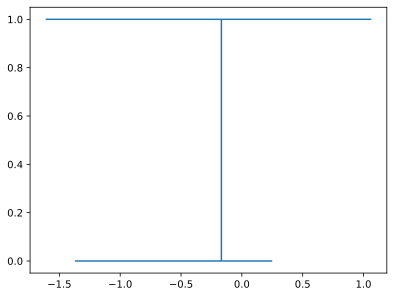

In [127]:
(yHat>0).float()

plt.plot(yHat.detach().numpy(),lab)
# 2,30,31,31

In [128]:
# arr = np.array([])

# for i in range(2):


tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)

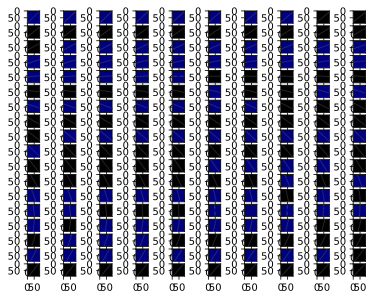

In [129]:
n=90
fig,ax  = plt.subplots(18,10)
for j in range(18):
  for i in range(10):
    if int( labels[i+(10*j)] ==(yHat>0).float()[i+(10*j)]):
      ax[j,i].imshow(data[i+10*(j),0,:,:],cmap='gray')
      print(labels[i+(10*j)] ==(yHat>0).float()[i+(10*j)],)
    else:
      ax[j,i].imshow(data[i+10*(j),0,:,:],cmap='jet')


In [130]:
yHat
com = torch.tensor(labels) ==(yHat>0).float()

(-1.0, 1.0)

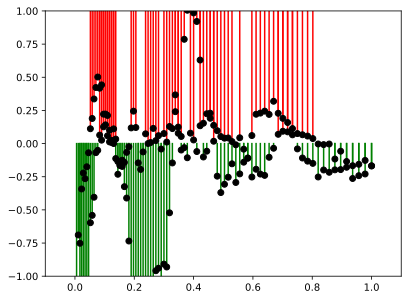

In [131]:
ridx = np.random.permutation(int(data.shape[0]-2))
datt = data[ridx,:,:,:].float()
slope = np.array(slope)
net.eval()
yhat = net(datt).detach()
datt = datt.detach()
for i in ridx:
  if yhat[i]>0:
    plt.plot([slope[ridx[i]],slope[ridx[i]]],[1,yhat[i]],'r')
  else:
    plt.plot([slope[ridx[i]],slope[ridx[i]]],[0,yhat[i]],'g')


plt.plot(slope[ridx],yhat,'ko')
plt.xlim([-0.1,1+1e-1])
plt.ylim([-1,1])